# Exploring the Alzheimer's prediction dataset from [kaggle](https://www.kaggle.com/datasets/ankushpanday1/alzheimers-prediction-dataset-global)

### Loading the Dataset

In [1]:
import pandas as pd

alzheimers = pd.read_csv("data/alzheimers.csv")

### Summary Statistics

In [ ]:
display(alzheimers.describe().style.set_caption("Numerical Columns"))
display(alzheimers.select_dtypes(include="object").describe().style.set_caption("Categorical Columns"))
display(alzheimers.info())

,Age,Education Level,BMI,Cognitive Test Score
count,74283.000000,74283.000000,74283.000000,74283.000000
mean,71.964703,9.487514,26.780639,64.654241
std,12.980748,5.757020,4.764679,20.153247
min,50.000000,0.000000,18.500000,30.000000
25%,61.000000,4.000000,22.700000,47.000000
50%,72.000000,9.000000,26.800000,65.000000
75%,83.000000,14.000000,30.900000,82.000000
max,94.000000,19.000000,35.000000,99.000000


,Country,Gender,Physical Activity Level,Smoking Status,Alcohol Consumption,Diabetes,Hypertension,Cholesterol Level,Family History of Alzheimer’s,Depression Level,Sleep Quality,Dietary Habits,Air Pollution Exposure,Employment Status,Marital Status,Genetic Risk Factor (APOE-ε4 allele),Social Engagement Level,Income Level,Stress Levels,Urban vs Rural Living,Alzheimer’s Diagnosis
count,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283
unique,20,2,3,3,3,2,2,2,2,3,3,3,3,3,3,2,3,3,3,2,2
top,Brazil,Female,High,Current,Never,No,No,Normal,No,Medium,Good,Average,High,Unemployed,Single,No,Medium,Low,Medium,Rural,No
freq,3839,37249,24853,24915,24865,59527,52134,51973,52004,24843,25145,24917,24906,24801,25169,59561,24859,24873,24886,37203,43570


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74283 entries, 0 to 74282
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Country                               74283 non-null  object 
 1   Age                                   74283 non-null  int64  
 2   Gender                                74283 non-null  object 
 3   Education Level                       74283 non-null  int64  
 4   BMI                                   74283 non-null  float64
 5   Physical Activity Level               74283 non-null  object 
 6   Smoking Status                        74283 non-null  object 
 7   Alcohol Consumption                   74283 non-null  object 
 8   Diabetes                              74283 non-null  object 
 9   Hypertension                          74283 non-null  object 
 10  Cholesterol Level                     74283 non-null  object 
 11  Family History 

None

This dataset appears to be very clean.
- No missing values, the row counts for each attribute remain consistent for all.
- Data types appear as expected.
- Frequency counts for categorical variables show a good distribution for each.

### Univariate Analysis

Linear correlation analysis:

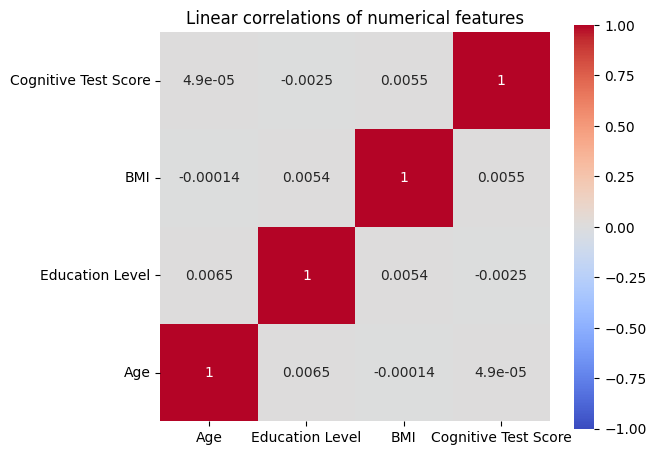

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(alzheimers.select_dtypes(include='number').corr().iloc[::-1], vmin=-1, vmax=1, cmap='coolwarm', annot=True, square=True)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.title("Linear correlations of numerical features")
plt.tight_layout()
plt.show()

# Preprocessing

In [2]:
from preprocessing import alzheimers_preprocessing

alzheimers_encoded = alzheimers_preprocessing(alzheimers)

Saving to CSV

In [ ]:
alzheimers_encoded.to_csv("data/alzheimers_encoded.csv", index=False)

# Modeling

### Feature Selection

In [4]:
import pandas as pd

alzheimers = pd.read_csv("data/alzheimers.csv")
alzheimers_encoded = pd.read_csv("data/alzheimers_encoded.csv")

feature_names = alzheimers_encoded.columns
numerical_data = alzheimers_encoded.drop(columns=["Alzheimers_Diagnosis_Yes"])
target = alzheimers_encoded['Alzheimers_Diagnosis_Yes']

Helper timer decorator

In [5]:
import time
from functools import wraps

def time_it():
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            start = time.perf_counter()
            result = func(*args, **kwargs)
            end = time.perf_counter()
            print(f"[TIMER] {func.__name__} took {end - start:.4f} seconds")
            return result
        return wrapper
    return decorator

### CV Strategy

In [6]:
from sklearn.model_selection import train_test_split, KFold
import numpy as np
from sklearn.model_selection import cross_validate

# def evaluate(X, y, model):
#     predictions = model.predict(X, y)
#     accuracy = np.sum(predictions == y) / predictions.__len__()
#     return accuracy

# def basic_tt_split_validation(X, y, model, train_size = 0.80):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = train_size)
#     model.fit(X_train, y_train)
#     return evaluate(X_test, y_test, model)

# def kfold_tt_split_validation(X, y, model, n_splits = 5):
#     kf = KFold(n_splits = n_splits, shuffle = True)
#     metrics = []
#     for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
#         X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
#         model.fit(X_train, y_train)
#         metrics.append(evaluate(X_test, y_test, model))
#     return metrics

@time_it()
def evaluate_model(estimator, X, y, cv):
    scoring = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]
    cv_results = cross_validate(estimator, X, y, scoring=scoring, cv=cv, n_jobs=-1)

    metrics = {
        "accuracy": np.mean(cv_results["test_accuracy"]),
        "precision": np.mean(cv_results["test_precision_macro"]),
        "recall": np.mean(cv_results["test_recall_macro"]),
        "f1": np.mean(cv_results["test_f1_macro"]),
    }
    return metrics

### Modeling and Results

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1337)

estimators = {
    "LogisticRegression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier(eval_metric="logloss"),
    "NaiveBayes": GaussianNB(),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "KNN": KNeighborsClassifier(),
    "SVM": LinearSVC(C=1.0)
}

results = {}

for name, model in estimators.items():
    print(f"Running {name} evaluation:")
    metrics = evaluate_model(model, numerical_data, target, skf)
    results[name] = metrics

for name, metrics_dict in results.items():
    print(f"\n{name} Metrics:")
    for metric_name, metric_val in metrics_dict.items():
        print(f"\t{metric_name}: {metric_val:.4f}")

Running LogisticRegression evaluation:
[TIMER] evaluate_model took 3.4549 seconds
Running RandomForest evaluation:
[TIMER] evaluate_model took 15.2409 seconds
Running XGBoost evaluation:
[TIMER] evaluate_model took 1.6754 seconds
Running NaiveBayes evaluation:
[TIMER] evaluate_model took 0.4852 seconds
Running LDA evaluation:
[TIMER] evaluate_model took 1.6392 seconds
Running QDA evaluation:
[TIMER] evaluate_model took 1.6333 seconds
Running KNN evaluation:
[TIMER] evaluate_model took 7.1464 seconds
Running SVM evaluation:
[TIMER] evaluate_model took 1.1172 seconds

LogisticRegression Metrics:
	accuracy: 0.7149
	precision: 0.7061
	recall: 0.6992
	f1: 0.7015

RandomForest Metrics:
	accuracy: 0.7201
	precision: 0.7113
	recall: 0.7077
	f1: 0.7091

XGBoost Metrics:
	accuracy: 0.7148
	precision: 0.7058
	recall: 0.7047
	f1: 0.7052

NaiveBayes Metrics:
	accuracy: 0.6377
	precision: 0.6251
	recall: 0.6234
	f1: 0.6240

LDA Metrics:
	accuracy: 0.7154
	precision: 0.7065
	recall: 0.7006
	f1: 0.702

# Feature Importances

Only some models have `feature_importances_` or `coef_`, the most straightforward metrics for feature importance. We will only be doing feature importance analysis on those models that have such attributes:

In [31]:
def get_feature_importances(model, feature_names):
    # Tree based models usually have a feature_importances_ attribute
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        return list(zip(feature_names, importances))

    # Linear models usually have a coef_ attribute
    elif hasattr(model, "coef_"):
        coef = model.coef_
        importances = np.abs(coef[0])

        return list(zip(feature_names, importances))
    else:
        return None


def run_feature_importance_analysis(num_importances=5):
    fitted_models = {}
    for name, model in estimators.items():
        print(f"Fitting {name} ...")
        model.fit(numerical_data, target)
        fitted_models[name] = model

    for name, model in fitted_models.items():
        importances = get_feature_importances(model, feature_names)
        if importances is not None:
            print(f"\n{name} feature importances:")
            for feat, val in sorted(importances, key=lambda x: x[1], reverse=True)[:5]:
                print(f"\t{feat}: {val:.4f}")
        else:
            print(f"\n{name} does not provide a direct feature importance measure.")

run_feature_importance_analysis()

Fitting LogisticRegression ...
Fitting RandomForest ...
Fitting XGBoost ...
Fitting NaiveBayes ...
Fitting LDA ...
Fitting QDA ...
Fitting KNN ...

LogisticRegression feature importances:
   Genetic_Risk_Factor_(APOE-ε4_allele)_Yes: 1.2644
   Age: 1.0653
   Family_History_of_Alzheimers_Yes: 0.8254
   Country_Russia: 0.5904
   Country_India: 0.5464

RandomForest feature importances:
   Age: 0.2509
   BMI: 0.0818
   Cognitive_Test_Score: 0.0776
   Education_Level: 0.0649
   Genetic_Risk_Factor_(APOE-ε4_allele)_Yes: 0.0366

XGBoost feature importances:
   Genetic_Risk_Factor_(APOE-ε4_allele)_Yes: 0.2010
   Age: 0.1338
   Family_History_of_Alzheimers_Yes: 0.0960
   Country_South_Africa: 0.0249
   Country_Russia: 0.0246

NaiveBayes does not provide a direct feature importance measure.

LDA feature importances:
   Genetic_Risk_Factor_(APOE-ε4_allele)_Yes: 1.3064
   Age: 1.1303
   Family_History_of_Alzheimers_Yes: 0.8412
   Country_Russia: 0.5974
   Country_India: 0.5563

QDA does not provide

Fitting RandomForest ...
Finished fitting


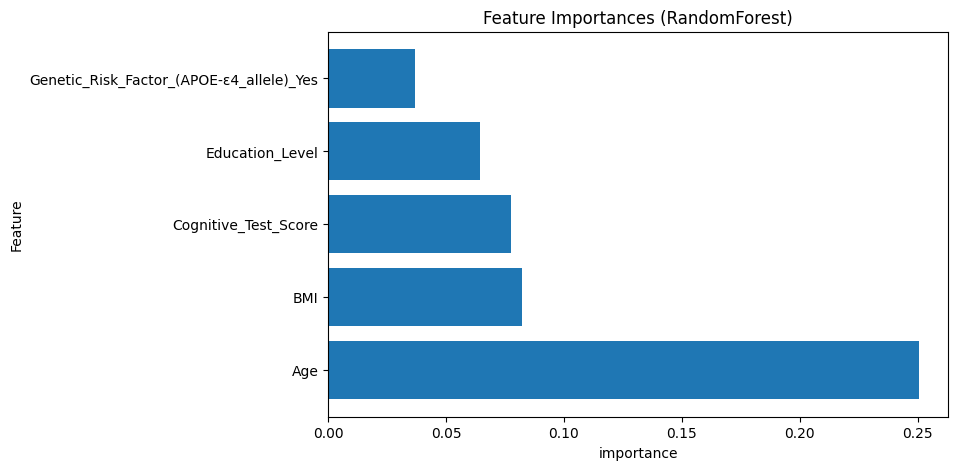

In [41]:
import matplotlib.pyplot as plt
def plot_feature_importance(model_name, num_importances = 5):
    if model_name in estimators.keys():
        print(f"Fitting {model_name} ...")
        model = estimators[model_name]        
        model.fit(numerical_data, target)
        print("Finished fitting")
        importances = get_feature_importances(model, numerical_data.columns)
        sorted_importances = sorted(importances, key=lambda x: x[1], reverse=True)
        top_importances = sorted_importances[:num_importances]
        # Separate names and values for plotting
        labels = [t[0] for t in top_importances]
        values = [t[1] for t in top_importances]
        
        # Create a bar plot
        plt.figure(figsize=(8, 5))
        plt.barh(range(len(values)), values)
        plt.yticks(range(len(values)), labels)
        plt.title(f"Feature Importances ({model_name})")
        plt.xlabel("importance")
        plt.ylabel("Feature")
        plt.show()

plot_feature_importance("RandomForest")